<a href="https://colab.research.google.com/github/appleBattery/Eye-based-Verification/blob/master/Training_on_IITD_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize

In [ ]:
from google.colab import drive
from google.colab import files

In [ ]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import dependencies

In [ ]:
import torchvision.models as models
from torchvision import transforms
import torch
import h5py
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

### Load dataset from h5

In [ ]:
autobots = transforms.Compose([transforms.Resize((224,224)), # Transformations on the input images
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [ ]:
#resNet50 = models.resnet50(pretrained=True) # pretrained model

loc = '/content/drive/My Drive/iris detection/data/iitd.h5' # loading the iitd image dataset from hdf5 file
with h5py.File(loc,'r') as f:
  iitd_R = np.array(f['R'])
  iitd_L = np.array(f['L'])

iitd_R.shape,iitd_L.shape # sanity check: 208*5, image dimensions

((1040, 240, 320, 3), (1040, 240, 320, 3))

In [ ]:
n = len(iitd_R)
l_eye = np.zeros((n,3,224,224),np.float16)
r_eye = np.zeros((n,3,224,224),np.float16)
for i in range(n):
  img = Image.fromarray(iitd_R[i,:],'RGB')
  trans_img = autobots(img)
  img = trans_img.numpy()
  r_eye[i,:] = img
  img = Image.fromarray(iitd_L[i,:],'RGB')
  trans_img = autobots(img)
  img = trans_img.numpy()
  l_eye[i,:] = img

iitd_R = None; iitd_L = None

### Create positive and negative image sets and store them in an array

In [ ]:
X = np.zeros((8320,2,3,224,224),np.float16)
Y = np.zeros((8320,1),np.float16)

c = 0; l=l_eye.shape[0] # for positive sets left eye
for i in range(0,l//5):
  for j in range(i*5,i*5+5):
    for k in range(j+1,i*5+5):
      X[c,0,:]=l_eye[j,:]
      X[c,1,:]=l_eye[k,:]
      c+=1

n = 2080; # for negative sets (choose n number of random samples) for left eye
while(n>0):
  i = np.random.randint(0,l-1)
  if ((i//5)*5 == (l-5)):
    j = np.random.randint(0,(i//5)*5-1)
  elif ((i//5) == 0):
    j= np.random.randint((i//5 + 1)*5,l-1)
  else:
    j1=np.random.randint(0,(i//5)*5-1); j2= np.random.randint((i//5 + 1)*5,l-1)
    j = j1 if np.random.uniform()>0.5 else j2
  if i!=j:
    X[c,0,:]=l_eye[i,:]
    X[c,1,:]=l_eye[j,:]
    c+=1; n-=1

 # for positive sets right eye
for i in range(0,l//5):
  for j in range(i*5,i*5+5):
    for k in range(j+1,i*5+5):
      X[c,0,:]=r_eye[j,:]
      X[c,1,:]=r_eye[k,:]
      c+=1

n = 2080;  # for negative sets (choose n number of random samples) for right eye
while(n>0):
  i = np.random.randint(0,l-1)
  if ((i//5)*5 == (l-5)):
    j = np.random.randint(0,(i//5)*5-1)
  elif ((i//5) == 0):
    j= np.random.randint((i//5 + 1)*5,l-1)
  else:
    j1=np.random.randint(0,(i//5)*5-1); j2= np.random.randint((i//5 + 1)*5,l-1)
    j = j1 if np.random.uniform()>0.5 else j2
  if i!=j:
    X[c,0,:]=r_eye[i,:]
    X[c,1,:]=r_eye[j,:]
    c+=1; n-=1

for i in range(0,2080):
  Y[i] = 1 # for positive sets
for i in range(2080,4160):
  Y[i] = 0 # for negative sets
for i in range(4160,6240):
  Y[i] = 1 # for positive sets
for i in range(6240,8320):
  Y[i] = 0 # for negative sets


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=11)

X = None # clear them from memory
Y = None

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

### Define the custom classifier which includes the pretrained model as the first sequential.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class iris_classifier(nn.Module):
  def __init__(self):
    super(iris_classifier, self).__init__()
    self.resNet50 = models.resnet50(pretrained=True)
    # Here you get the bottleneck/feature extractor
    modules=list(self.resNet50.children())[:-1]
    self.resNet50 = torch.nn.Sequential(*modules)

    self.resNet50.flat = torch.nn.Flatten()
    
    for param in self.resNet50.parameters():
      param.requires_grad = False # freeze all layers of the convnet
    
    self.fc1 = nn.Linear(2048,1024)
    self.fc2 = nn.Linear(1024,128)
    self.fc3 = nn.Linear(256,16)
    self.fc4 = nn.Linear(16,1)

    # Set your own forward pass
  def forward(self, img1, img2):
    self.resNet50.eval()
    out1 = self.resNet50(img1)
    out2 = self.resNet50(img2)
    
    out1 = F.relu(self.fc1(out1))
    out2 = F.relu(self.fc1(out2))
    out1 = F.relu(self.fc2(out1))
    out2 = F.relu(self.fc2(out2))

    out = torch.cat((out1,out2),1)

    out = F.relu(self.fc3(out))
    out = self.fc4(out)

    return out

classifier = iris_classifier()
classifier = classifier.to(device)
print(classifier)

cuda:0
iris_classifier(
  (resNet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### Building the Dataset class pytorch

In [ ]:
class train_dataset(Dataset):
  def __init__(self):
    self.samples = {'X': X_train,'Y': Y_train}
  def __len__(self):
    return self.samples['X'].shape[0]
  def __getitem__(self, idx):
    return (self.samples['X'][idx,0,:],self.samples['X'][idx,1,:],self.samples['Y'][idx])

In [ ]:
train_set = train_dataset()

### Training With dataloader class:

In [ ]:
size_batches = 128; no_batches = X_train.shape[0]//size_batches
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.9)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=size_batches,shuffle=True, num_workers = 1)

In [ ]:
loss_values = []
for epoch in range(100):  # loop over the dataset multiple times
  running_loss = 0.0
  
  for data in trainloader:
    img1_batch, img2_batch, labels = data
    img1_batch = img1_batch.to(device); img2_batch = img2_batch.to(device); labels = labels.to(device)
    img1_batch = img1_batch.type(torch.cuda.FloatTensor); img2_batch = img2_batch.type(torch.cuda.FloatTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    classifier.train()

    outputs = classifier(img1_batch,img2_batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #scheduler.step()

    running_loss += loss.item()
    #print(running_loss)
    #running_loss=0

  epoch_loss = round((running_loss/no_batches),8)
  print(epoch_loss)
  loss_values.append(epoch_loss)

print('Finished Training')

0.7058358
0.70417733
0.70224104
0.69861261
0.68566474
0.60561187
0.443734
0.40087049
0.3755893
0.36021476
0.34040149
0.33266475
0.31945169
0.3081665
0.30865479
0.29478718
0.29278775
0.28383873
0.27774784
0.26936077
0.27250724
0.27008899
0.26243013
0.24903817
0.24347976
0.23659542
0.22695607
0.21879841
0.21562563
0.21399978
0.20723751
0.20020268
0.19336779
0.20454459
0.19035287
0.17834473
0.17360082
0.18066932
0.16774671
0.15824732
0.1567225
0.15813999
0.13979682
0.12922248
0.116353
0.11966942
0.103845
0.09629927
0.08942597
0.07541341
0.06731257
0.07361813
0.06298881
0.06294829
0.06444523
0.05109932
0.0495295
0.03951961
0.03652638
0.04451226
0.04239799
0.03927152
0.04427088
0.04386422
0.03632407
0.02492556
0.02496568
0.02311417
0.0320551
0.02680693
0.02618803
0.02408113
0.01902679
0.01141686
0.01040926
0.00718765
0.00677163
0.00455194
0.00412904
0.00604728
0.00354142
0.00254731
0.00199809
0.00167447
0.00149942
0.00132414
0.00129501
0.00117173
0.00124299
0.00110513
0.00114413
0.00099374


### Save and load Trained Model

In [ ]:
path = '/content/drive/My Drive/iris detection/data/'
torch.save(classifier.state_dict(), path+'model0_100.pth')

In [ ]:
loss_values1 = np.array(loss_values)
loss_values0 = np.load('/content/drive/My Drive/iris detection/data/model1_losses.npy')
loss_values1 = np.expand_dims(loss_values1,0)
loss_values0 = np.expand_dims(loss_values0,0)
loss_values = np.concatenate((loss_values0,loss_values1),axis=1)

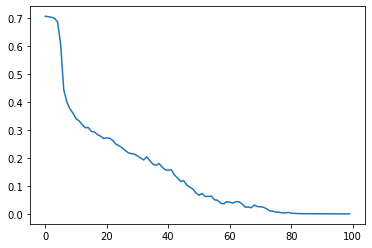

In [ ]:
loss_values = np.squeeze(loss_values)
plt.plot(loss_values)

In [ ]:
np.save('/content/drive/My Drive/iris detection/data/model0_losses.npy',loss_values)

In [ ]:
the_model = iris_classifier()
the_model.load_state_dict(torch.load(path))

<All keys matched successfully>

### To check what parameters are being trained:

In [ ]:
for name, param in classifier.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
print(classifier.resNet50.fc.weight[:,0])

### Testing of trained model

In [ ]:
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

In [ ]:
class test_dataset(Dataset):
  def __init__(self):
    self.samples = {'X': X_test,'Y': Y_test}
  def __len__(self):
    return self.samples['X'].shape[0]
  def __getitem__(self, idx):
    return (self.samples['X'][idx,0,:],self.samples['X'][idx,1,:],self.samples['Y'][idx])

test_set = test_dataset()

In [ ]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=True, num_workers = 1)

In [ ]:
acc=[];
for data in testloader:
  img1_batch, img2_batch, labels = data
  img1_batch = img1_batch.to(device); img2_batch = img2_batch.to(device);
  img1_batch = img1_batch.type(torch.cuda.FloatTensor); img2_batch = img2_batch.type(torch.cuda.FloatTensor)

  out = classifier(img1_batch,img2_batch)
  out = torch.sigmoid(out.cpu())
  predict = out.detach().numpy()
  labels = labels.numpy()
  predict[predict>=0.5] = 1.
  predict[predict<0.5] = 0.
  acc.append(predict==labels)

acc = np.array(acc)
acc = acc.flatten()
print(np.mean(acc))

0.9495192307692307
